# Fitting Saturation-based Simulation Data With Multi-Output
Can having multiple labels per data improve validation loss? 


In [113]:
from pathlib import Path
import json
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn import preprocessing
from inverse_modelling_tfo.data import (
    generate_data_loaders,
    equidistance_detector_normalization,
    constant_detector_count_normalization,
    config_based_normalization
)
from inverse_modelling_tfo.data.intensity_interpolation import (
    interpolate_exp,
    get_interpolate_fit_params,
    exp_piecewise_affine,
)
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from inverse_modelling_tfo.models import RandomSplit, ValidationMethod, HoldOneOut, CVSplit, CombineMethods
from inverse_modelling_tfo.models.custom_models import (
    PerceptronBD,
    CNN2FC,
    FeatureResidualNetwork,
    CNN2FC2dInput,
    SplitChannelCNN
)
from inverse_modelling_tfo.features.build_features import (
    FetalACFeatureBuilder,
    RowCombinationFeatureBuilder,
    TwoColumnOperationFeatureBuilder,
    FetalACbyDCFeatureBuilder,
    LogTransformFeatureBuilder,
    ConcatenateFeatureBuilder,
)
from inverse_modelling_tfo.features.data_transformations import (
    LongToWideIntensityTransformation,
    ToFittingParameterTransformation,
)
from inverse_modelling_tfo.visualization import generate_model_error_and_prediction
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import torchinfo
from inverse_modelling_tfo.misc.misc_training import set_seed

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [114]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Pre-save data

In [115]:
# file_name = 'logI2_by_I1'
file_name = 'I1_and_I2_no_interp'
# Load data
DATA_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.pkl"
data = pd.read_pickle(DATA_PATH)

# Load Configs
CONFIG_PATH = Path().resolve().parent.parent / "data" / "processed_data" / f"{file_name}.json"
with open(CONFIG_PATH, "r") as f:
    config = json.load(f)
labels = config["labels"]
features = config["features"]

# Convert to log
data[features] = np.log(data[features])


# Cleanup
data.dropna(inplace=True)

In [116]:
# Filter data so I don't have to wait for too long during training
data = data[
    (data["Maternal Wall Thickness"] >= 2.0)
    & (data["Maternal Wall Thickness"] <= 12.0)
    # & (np.round(data["Fetal Hb Concentration"], fconc_rounding).isin(groups_to_keep))
    & (data["Fetal Saturation"] > 0.3)
    & (data["Maternal Saturation"] > 0.95)
]
print("training with", len(data), "samples")

training with 90720 samples


## Fetal AC by DC Feature

In [117]:
# fb1 = FetalACbyDCFeatureBuilder('FconcCenters', pairing_type, intensity_columns, labels, "max")
# # feature_builder2 = TwoColumnOperationFeatureBuilder(x_columns1[len(x_columns1)//2:], x_columns1[:len(x_columns1)//2], "/", False, x_columns1, feature_builder1.get_label_names())

## Row Combination Spatial Intensity (or their Log)

In [118]:
# fixed_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Saturation", "FconcCenters"]
# fb3 = RowCombinationFeatureBuilder(intensity_columns, fixed_columns, ["Fetal Hb Concentration"], pairing_type, 2)
# # feature_builder4 = LogTransformFeatureBuilder(feature_builder3.get_feature_names(), feature_builder3.get_feature_names(), feature_builder3.get_label_names())

## Fetal AC_wv1 by AC_wv2 Feature Builder

In [119]:
# fb5 = FetalACFeatureBuilder('FconcCenters', pairing_type, '/', intensity_columns, labels)
# x_columns5 = fb5.get_feature_names()
# fb6 = TwoColumnOperationFeatureBuilder.from_chain(fb5, x_columns5[len(x_columns5)//2:], x_columns5[:len(x_columns5)//2], "/", False)

## Fitting Parameters

In [120]:
# fb0 = RowCombinationFeatureBuilder(fitting_param_transformer.get_feature_names(), fixed_columns, ["Fetal Hb Concentration"], pairing_type, 2)
# x_columns0 = fb0.get_feature_names()   
# fb7 = TwoColumnOperationFeatureBuilder.from_chain(fb0, x_columns0[:len(x_columns0)//2], x_columns0[len(x_columns0)//2:], '*', True)
# data1 = fb7(fitting_params)

## Combining Them Together

In [121]:
# fb_concat = ConcatenateFeatureBuilder([fb1, fb3, fb6])
# fb_concat = ConcatenateFeatureBuilder([fb3, fb6])
# data = fb_concat(data)

# data = fb1(data)
# print(len(data))

In [122]:
# data = pd.concat([data1[labels], data1[feature_builder2.get_fea`ture_names()], data2[feature_builder4.get_feature_names()]], axis=1)
# data = pd.concat([data1[fb1.get_label_names()], data1[fb1.get_feature_names()], data2[fb3.get_feature_names()], data3[fb5.get_feature_names()], data4[fb7.get_feature_names()]], axis=1)
# labels = fb_concat.get_label_names()
# labels = fb1.get_label_names()
# data = pd.merge(data1, data2, on=labels, how='inner')
# labels = fb3.get_label_names()

In [123]:
# Define the input & output parameters to the NN
# x_columns = fb_concat.get_feature_names() + fb7.get_feature_names()
# x_columns = fb_concat.get_feature_names()
# x_columns = fb1.get_feature_names()
# x_columns = fb7.get_feature_names()  + fb_concat.get_feature_names()[::2]
# x_columns = fb3.get_feature_names()
# y_columns = fb_concat.get_label_names()
# y_columns = fb3.get_label_names()
# y_columns = fb1.get_label_names()

# Setup Training Objective

In [124]:
y_columns = labels  # What to Predict
# Add New ConcDiff Column as a new label
# data["ConcDiff"] = data["Fetal Hb Concentration 1"] - data["Fetal Hb Concentration 0"]
# if "ConcDiff" not in y_columns:
#     y_columns.append("ConcDiff")

# if "Fetal Hb Concentration 1" in y_columns:
#     y_columns.remove("Fetal Hb Concentration 1")

# if "Fetal Hb Concentration 0" in y_columns:
#     y_columns.remove("Fetal Hb Concentration 0")

if "FconcCenters" in y_columns:
    y_columns.remove("FconcCenters")
print("Y Columns", y_columns)

x_columns = features  # What to use as input
print("X Columns", x_columns)

Y Columns ['Maternal Wall Thickness', 'Maternal Hb Concentration', 'Maternal Saturation', 'Fetal Saturation', 'Fetal Hb Concentration 0', 'Fetal Hb Concentration 1']
X Columns ['10_2.0_1', '15_2.0_1', '19_2.0_1', '24_2.0_1', '28_2.0_1', '33_2.0_1', '37_2.0_1', '41_2.0_1', '46_2.0_1', '50_2.0_1', '55_2.0_1', '59_2.0_1', '64_2.0_1', '68_2.0_1', '72_2.0_1', '77_2.0_1', '81_2.0_1', '86_2.0_1', '90_2.0_1', '94_2.0_1', '10_1.0_1', '15_1.0_1', '19_1.0_1', '24_1.0_1', '28_1.0_1', '33_1.0_1', '37_1.0_1', '41_1.0_1', '46_1.0_1', '50_1.0_1', '55_1.0_1', '59_1.0_1', '64_1.0_1', '68_1.0_1', '72_1.0_1', '77_1.0_1', '81_1.0_1', '86_1.0_1', '90_1.0_1', '94_1.0_1', '10_2.0_2', '15_2.0_2', '19_2.0_2', '24_2.0_2', '28_2.0_2', '33_2.0_2', '37_2.0_2', '41_2.0_2', '46_2.0_2', '50_2.0_2', '55_2.0_2', '59_2.0_2', '64_2.0_2', '68_2.0_2', '72_2.0_2', '77_2.0_2', '81_2.0_2', '86_2.0_2', '90_2.0_2', '94_2.0_2', '10_1.0_2', '15_1.0_2', '19_1.0_2', '24_1.0_2', '28_1.0_2', '33_1.0_2', '37_1.0_2', '41_1.0_2', '46_1.0

## Normalizing Features
x_columns will be the input features and y_columns are the target

In [125]:
## Pass in maternal info
# x_columns += ["Maternal Hb Concentration", "Maternal Saturation"]
# x_columns = list(filter(lambda X: 'alpha' in X, data.columns))

## Scale y
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

## Scale x
x_scaler = preprocessing.StandardScaler()
data[x_columns] = x_scaler.fit_transform(data[x_columns])

# Custom Loss Definition

In [126]:
class WeightedMSE(nn.Module):
    """
    MSE Loss for vector output labels with custom weighting
    """
    def __init__(self, loss_weights: torch.Tensor) -> None:
        super().__init__()
        # Reshape to row vector for broadcasting during loss calculation
        self.loss_weights = loss_weights.reshape(1, -1)
        self.mse_loss = nn.MSELoss(reduction='none')

    
    def forward(self, predicted_tmps, targets):
        loss = self.mse_loss(predicted_tmps, targets)
        loss = loss * self.loss_weights
        return loss.sum() / self.loss_weights.sum()

## Model Configuration

In [127]:
print("In Features :", len(x_columns))  
print("Out Features:", len(y_columns))

In Features : 80
Out Features: 6


# Setting up Special Residual Network 

In [128]:
# saturation_unique_values = data["Fetal Saturation"].unique()
# mean_saturation_level = saturation_unique_values[len(saturation_unique_values)//2]
# # Convert to float tensor, by default it is double
# lookup_table = torch.from_numpy(data[data["Fetal Saturation"] == mean_saturation_level].values).cuda().float()
# feature_indices = [data.columns.get_loc(feature) for feature in x_columns]
# feature_indices = torch.tensor(feature_indices).cuda()
# intermediate_labels = y_columns.copy()
# intermediate_labels.remove("Fetal Saturation")
# intermediate_label_indices = [data.columns.get_loc(label) for label in intermediate_labels]
# intermediate_labels = torch.tensor(intermediate_label_indices).cuda()

# # y_columns = ["Fetal Saturation"]

# feature_res_net_params = {
#         'node_count_left': [len(x_columns), 5, len(intermediate_labels)],
#         'dropout_rates_left': [0.5, 0.5],
#         'node_count_right': [len(x_columns), 5, len(y_columns)],
#         'dropout_rates_right': [0.5, 0.5],
#         'lookup_table': lookup_table,
#         'lookup_key_indices': intermediate_labels,
#         'feature_indices': feature_indices,
# }


# Training Configs

In [129]:
IN_FEATURES = len(x_columns)
OUT_FEATURES = len(y_columns)

from inverse_modelling_tfo.models.train_model import ModelTrainerFactory
datagen_kw = {
    'table' : data,
    'data_loader_params' : 
        {
            'batch_size': 32, 'shuffle': True
        }, 
    'x_columns': x_columns,
    'y_columns': y_columns,
    'validation_method' : RandomSplit(0.9)
    # 'validation_method' : HoldOneOut('Maternal Wall Thickness', data['Maternal Wall Thickness'].unique()[3])
    # 'validation_method' : CombineMethods([HoldOneOut('Maternal Wall Thickness', data['Maternal Wall Thickness'].unique()[3]), RandomSplit(0.9)])
    # 'validation_method' : HoldOneOut('Maternal Hb Concentration', 13.0)
    # 'validation_method' : HoldOneOut('Maternal Saturation', 1.0)
}

# criterion = WeightedMSE(torch.Tensor([1.0, 1.0, 1.0,  1.2, 1.0, 1.0]).cuda())
# criterion = WeightedMSE(torch.Tensor([4.0, 1.0, 1.0, 1.0, 1.0, 1.0]).cuda())
criterion = nn.MSELoss()
# criterion = nn.HuberLoss()

## Trainer Factory - Perceptrons
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 40, 20, 10, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 25, 12, 8, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 10, 10, 5, 5, OUT_FEATURES], 'dropout_rates': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5]}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(PerceptronBD, {'node_counts' : [IN_FEATURES, 40, 20, 10, 5, OUT_FEATURES], 'dropout_rates': [0.5] * 5}, generate_data_loaders, datagen_kw, 100, criterion)
# trainer_factory = ModelTrainerFactory(FeatureResidualNetwork, feature_res_net_params, generate_data_loaders, datagen_kw, 100, criterion)

## Trainer Factory - CNNs
# cnn_config = {
#     'input_length': IN_FEATURES,
#     'cnn_out_channels': [4, 8, 16],
#     'cnn_kernel_sizes' : [10, 10, 10],
#     'fc_output_node_counts': [20, 10, OUT_FEATURES],
# }
# trainer_factory = ModelTrainerFactory(CNN2FC2dInput, cnn_config, generate_data_loaders, datagen_kw, 100, criterion)

## Trainer Factory - SplitChannel CNNs
cnn_config = {
    'complete_input_length': IN_FEATURES,
    'split_count': 4,
    'cnn_out_channels': [4, 8, 16],
    # 'cnn_kernel_sizes' : [10, 5, 5],
    'cnn_kernel_sizes' : [10, 5, 3],
    'cnn_dropouts' : [0.5] * 2,
    # 'fc_output_node_counts': [30, 10, OUT_FEATURES],    # Best
    # 'fc_output_node_counts': [24, 12, OUT_FEATURES],    # Best
    'fc_output_node_counts': [12, 6, OUT_FEATURES],    # Best
    'fc_dropouts': [0.5] * 3,
}
trainer_factory = ModelTrainerFactory(SplitChannelCNN, cnn_config, generate_data_loaders, datagen_kw, 100, criterion)

## Hyper Parameter Tuning

In [130]:
# # Custom Train Function
# def train_with_tuning(iteration_config):
#     set_seed(42)
#     trainer_tuning = trainer_factory.create()
#     trainer_tuning.reporting = True  # Report at each epoch to Ray Tune
#     if "batch_size" in iteration_config:
#         trainer_tuning.change_batch_size(iteration_config["batch_size"])  # If batch_size needs tuning
#     trainer_tuning.set_optimizer(SGD, {"lr": iteration_config["lr"], "momentum": iteration_config["momentum"]})
#     trainer_tuning.run()

In [131]:
# from ray import tune
# from ray.tune import CLIReporter
# from ray.tune.schedulers import ASHAScheduler

# # Hyper Parameter Search
# iteration_config = {
#     "lr" : tune.loguniform(1e-4, 1e-3),
#     "batch_size": tune.choice([32, 64, 128, 256]),
#     "momentum": tune.uniform(0.9, 0.95),
# }
# scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=60, grace_period=5, reduction_factor=2)
# reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
# result = tune.run(train_with_tuning, config=iteration_config, scheduler=scheduler, progress_reporter=reporter,
#                   num_samples=80, resources_per_trial={"cpu": 0, "gpu": 0.5},)

# best_trial = result.get_best_trial("val_loss", "min", "last")
# # best_trial = result.get_best_trial("combined_loss", "min", "last")
# print("Best trial config: {}".format(best_trial.config))
# print("Best trial final validation loss: {}".format(best_trial.last_result["val_loss"]))
# print("Best trial final train loss: {}".format(best_trial.last_result["train_loss"]))

<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

In [132]:
# best_trial.config

## Custom Training

In [144]:
set_seed(42)
trainer = trainer_factory.create()
trainer.set_optimizer(SGD, {'lr': 1e-3, 'momentum': 0.91, 'weight_decay': 1e-4})
# trainer.change_batch_size(2048)
trainer.change_batch_size(32)
trainer.epochs = 100
trainer.run()

# trainer.epochs = 30
# trainer.run() 

In [145]:
trainer.model.layers

[Conv1d(4, 4, kernel_size=(10,), stride=(1,), groups=4),
 BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Dropout1d(p=0.5, inplace=False),
 ReLU(),
 Conv1d(4, 8, kernel_size=(5,), stride=(1,), groups=4),
 BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Dropout1d(p=0.5, inplace=False),
 ReLU(),
 Conv1d(8, 16, kernel_size=(3,), stride=(1,), groups=4),
 Flatten(start_dim=1, end_dim=-1),
 Linear(in_features=80, out_features=12, bias=True),
 BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Dropout1d(p=0.5, inplace=False),
 ReLU(),
 Linear(in_features=12, out_features=6, bias=True),
 BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 Dropout1d(p=0.5, inplace=False),
 ReLU(),
 Linear(in_features=6, out_features=6, bias=True),
 Flatten(start_dim=1, end_dim=-1)]

In [146]:
# trainer.change_batch_size(64)
# trainer.epochs = 20
# trainer.change_batch_size(2048)
# trainer.epochs = 50
# trainer.run()

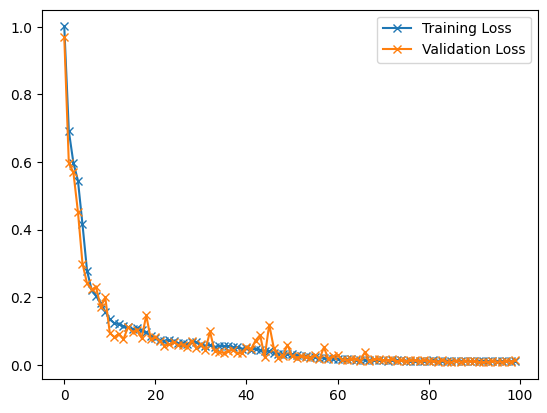

In [147]:
plt.figure()
plt.plot(trainer.train_loss, label='Training Loss', marker='x')
plt.plot(trainer.validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

loss_curves = plt.gcf()

In [148]:
print(trainer)


        Model Properties:
        SplitChannelCNN(
  (network): CNN2FC(
    (cnn): CNN1d(
      (model): Sequential(
        (0): Conv1d(4, 4, kernel_size=(10,), stride=(1,), groups=4)
        (1): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout1d(p=0.5, inplace=False)
        (3): ReLU()
        (4): Conv1d(4, 8, kernel_size=(5,), stride=(1,), groups=4)
        (5): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Dropout1d(p=0.5, inplace=False)
        (7): ReLU()
        (8): Conv1d(8, 16, kernel_size=(3,), stride=(1,), groups=4)
        (9): Flatten(start_dim=1, end_dim=-1)
      )
    )
    (fc): PerceptronBD(
      (model): Sequential(
        (0): Linear(in_features=80, out_features=12, bias=True)
        (1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout1d(p=0.5, inplace=False)
        (3): ReLU()
        (4): Linear(in_features=

In [149]:
# Increase batch_size for faster visuals generation - (does not affect training!)
trainer.change_batch_size(4096)
train_error, train_pred = generate_model_error_and_prediction(trainer.model, trainer.train_loader, y_columns, y_scaler)
val_error, val_pred = generate_model_error_and_prediction(trainer.model, trainer.validation_loader, y_columns, y_scaler)

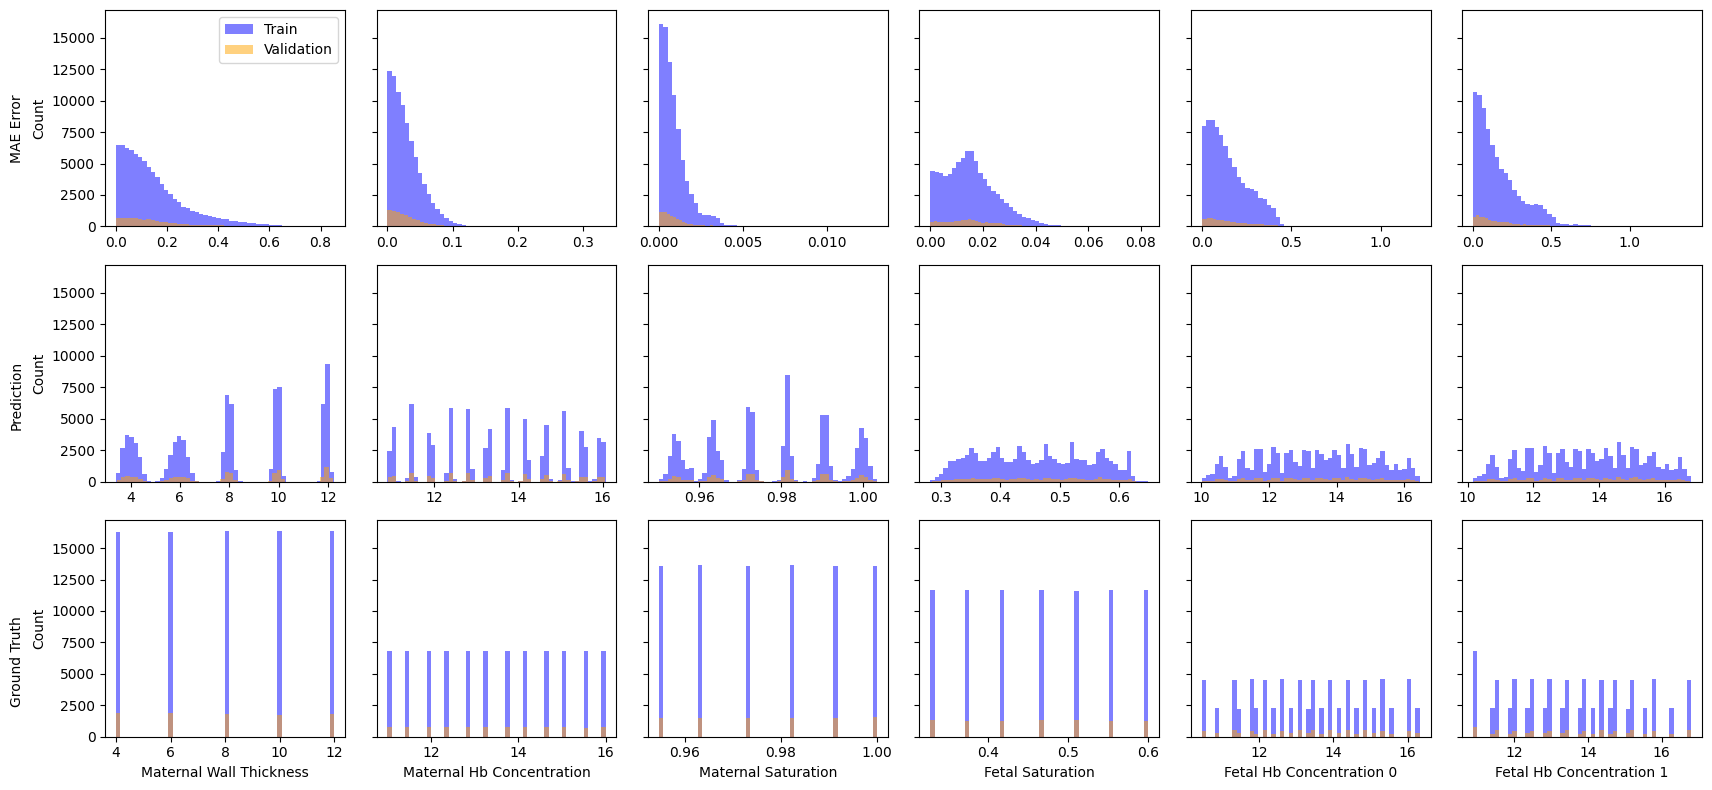

In [150]:
fig_dist, axes = plt.subplots(3, len(y_columns), squeeze=True, figsize=(17, 8), sharey=True)
BIN_COUNT = 50

train_data = y_scaler.inverse_transform(trainer.train_loader.dataset[:][1])
val_data = y_scaler.inverse_transform(trainer.validation_loader.dataset[:][1])

for i in range(len(y_columns)):
    # Plot Errors
    ax = axes[0, i]
    plt.sca(ax)
    column_name = train_error.columns[i]
    plt.hist(train_error[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_error[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Predictions
    ax = axes[1, i]
    plt.sca(ax)
    column_name = train_pred.columns[i]
    plt.hist(train_pred[column_name], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_pred[column_name], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    
    # Plot Ground Truth
    ax = axes[2, i]
    plt.sca(ax)
    plt.hist(train_data[:, i], bins=BIN_COUNT, color='blue', alpha=0.5, label='Train')
    plt.hist(val_data[:, i], bins=BIN_COUNT, color='orange', alpha=0.5, label='Validation')

    # X Label for the bottommost row
    plt.xlabel(y_columns[i])
    
# Add text to the left of each row of plots
for i, label in enumerate(['MAE Error', 'Prediction', 'Ground Truth']):
    fig_dist.text(0, (2.5-i)/3, label, ha='center', va='center', rotation='vertical')

# Y Labels
for i in range(axes.shape[0]):
    axes[i, 0].set_ylabel('Count')

# Add labels to top-left subplot
axes[0, 0].legend()


plt.tight_layout()
plt.show()

In [151]:
# # Top Bad Samples
# VIEW_TOP_N = 50
# worst_errors = error_df['Absolute Error'].argsort()[::-1][:VIEW_TOP_N]  # Worst Results
# # worst_errors = error_df['Absolute Error'].argsort()[:VIEW_TOP_N]  # Best Results
# combined_table = data.join(error_df)
# with pd.option_context("display.max_rows", None):
#     display(combined_table[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation", 'Truth', 'Predicted', 'Absolute Error', '%tage']].iloc[worst_errors, :])

In [152]:
# # Rough MSE's in percentage
# print(f'Train Error(non-normalized): {trainer.train_loss[-1] * y_scaler.var_ }')
# print(f'Validation Error(non-normalized): {trainer.validation_loss[-1] * y_scaler.var_ }')

In [153]:
# Model Info
torchinfo.summary(trainer.model)

Layer (type:depth-idx)                   Param #
SplitChannelCNN                          --
├─CNN2FC: 1-1                            --
│    └─CNN1d: 2-1                        --
│    │    └─Sequential: 3-1              228
│    └─PerceptronBD: 2-2                 --
│    │    └─Sequential: 3-2              1,128
Total params: 1,356
Trainable params: 1,356
Non-trainable params: 0

In [154]:
# model_name = 'msat_percep_irsi'
# import joblib
# # Save Model
# torch.save(model.state_dict(), rf'../models/{model_name}')
# # Save the Scalers for Later Use
# joblib.dump(x_scaler, rf'../models/{model_name}_xscaler')
# joblib.dump(y_scaler, rf'../models/{model_name}_yscaler')

In [155]:
# # Load Model Code
# model = PerceptronReLU([20, 10, 4, 2, 1])
# model.load_state_dict(torch.load(r'../models/fsat_delta_5det_v1'))
# model = model.cuda()
# x_scaler = joblib.load(rf'../models/{model_name}_xscaler')
# y_scaler = joblib.load(rf'../models/{model_name}_yscaler')

In [157]:
# from inverse_modelling_tfo.misc import MarkdownReport
# # Generate report

# report = MarkdownReport(Path('results'), 'report6', 'Inverse Modelling Report')
# report.add_text_report("Objective", "Predicting with 90% Random Split(As opposed to a hold One out style). The purpose of this is to set a baseline for how well these models would perform when predicting a single value at a time.")
# report.add_text_report("Comments", "The largest saturation error is 4% in MAE")
# report.add_text_report("Data Length", str(len(data)))
# report.add_code_report("Model Used", str(torchinfo.summary(trainer.model)))
# report.add_code_report("Model Trainer Params", str(trainer))
# report.add_image_report("Loss Curves", loss_curves)
# report.add_image_report("Prediction & Error Distribution", fig_dist)
# report.save_report()